# 準備

## ライブラリのインポート

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib

import json
import mca

import GPy

from sklearn.preprocessing import MinMaxScaler

## CSVの読み込み

In [497]:
playlist = pd.read_csv("/home/workspace/data/playlist.csv")
playlist.head()

,id,遊び,室内,室外,夏,冬,家の敷地内,街,山辺,海辺,...,運動,オンライン,オフライン,最低必要人数(わかんない場合は0),0〜2000円,2000〜4000円,4000〜6000円,6000円〜8000円,8000〜10000円,10000円〜
0,1,バーベキュー,0,1,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,0,0
1,2,キャンプ,0,1,1,0,0,0,1,1,...,0,0,1,1,0,0,1,1,1,1
2,3,温泉,1,0,1,1,0,1,1,1,...,0,0,1,1,1,0,0,0,0,0
3,4,博物館・美術館,1,0,1,1,0,1,0,0,...,0,0,1,1,1,0,0,0,0,0
4,5,飲み会(居酒屋),1,0,1,1,1,1,0,0,...,0,1,1,2,1,1,1,1,0,0


In [498]:
playlist.index = playlist["遊び"]
playlist = playlist.iloc[:,2:]
playlist = playlist.drop('最低必要人数(わかんない場合は0)', axis=1)
playlist.head(3)

,室内,室外,夏,冬,家の敷地内,街,山辺,海辺,のんびり,ワイワイ,...,動く(歩いたり…),運動,オンライン,オフライン,0〜2000円,2000〜4000円,4000〜6000円,6000円〜8000円,8000〜10000円,10000円〜
遊び,,,,,,,,,,,,,,,,,,,,,
バーベキュー,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,0,1,1,1,0,0
キャンプ,0,1,1,0,0,0,1,1,1,1,...,1,0,0,1,0,0,1,1,1,1
温泉,1,0,1,1,0,1,1,1,1,0,...,0,0,0,1,1,0,0,0,0,0


# 多重対応分析の適用

## データ加工

In [511]:
json = [{"id":1,"name":"バーベキュー","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":1,"sea":1,"nonbiri":0,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":0,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.487Z","updated_at":"2021-09-09T06:22:52.487Z"},{"id":2,"name":"キャンプ","indoor":0,"outdoor":1,"summer":1,"winter":0,"house":0,"town":0,"mountain":1,"sea":1,"nonbiri":1,"waiwai":1,"dont_move":1,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":1,"to_8000yen":1,"to_10000yen":1,"over_10000yen":1,"created_at":"2021-09-09T06:22:52.493Z","updated_at":"2021-09-09T06:22:52.493Z"},{"id":3,"name":"温泉","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":1,"sea":1,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.499Z","updated_at":"2021-09-09T06:22:52.499Z"},{"id":4,"name":"博物館・美術館","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.504Z","updated_at":"2021-09-09T06:22:52.504Z"},{"id":5,"name":"飲み会(居酒屋)","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.509Z","updated_at":"2021-09-09T06:22:52.509Z"},{"id":6,"name":"ショッピング","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":1,"over_10000yen":1,"created_at":"2021-09-09T06:22:52.513Z","updated_at":"2021-09-09T06:22:52.513Z"},{"id":7,"name":"遊園地","indoor":1,"outdoor":1,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":1,"to_8000yen":1,"to_10000yen":1,"over_10000yen":1,"created_at":"2021-09-09T06:22:52.518Z","updated_at":"2021-09-09T06:22:52.518Z"},{"id":8,"name":"動物園","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.523Z","updated_at":"2021-09-09T06:22:52.523Z"},{"id":9,"name":"水族館","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":1,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.527Z","updated_at":"2021-09-09T06:22:52.527Z"},{"id":10,"name":"カラオケ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":1,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.533Z","updated_at":"2021-09-09T06:22:52.533Z"},{"id":11,"name":"料理","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.538Z","updated_at":"2021-09-09T06:22:52.538Z"},{"id":12,"name":"ボルダリング","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.543Z","updated_at":"2021-09-09T06:22:52.543Z"},{"id":13,"name":"海へ観光","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":1,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.548Z","updated_at":"2021-09-09T06:22:52.548Z"},{"id":14,"name":"食べ歩き","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.554Z","updated_at":"2021-09-09T06:22:52.554Z"},{"id":15,"name":"フルーツ狩り","indoor":0,"outdoor":1,"summer":1,"winter":0,"house":0,"town":0,"mountain":1,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":0,"to_4000yen":1,"to_6000yen":1,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.560Z","updated_at":"2021-09-09T06:22:52.560Z"},{"id":16,"name":"アニマルカフェ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.565Z","updated_at":"2021-09-09T06:22:52.565Z"},{"id":17,"name":"サッカー","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.571Z","updated_at":"2021-09-09T06:22:52.571Z"},{"id":18,"name":"バスケ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.576Z","updated_at":"2021-09-09T06:22:52.576Z"},{"id":19,"name":"野球","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.580Z","updated_at":"2021-09-09T06:22:52.580Z"},{"id":20,"name":"映画館で映画を見る","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.585Z","updated_at":"2021-09-09T06:22:52.585Z"},{"id":21,"name":"読書・漫画を読む","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.591Z","updated_at":"2021-09-09T06:22:52.591Z"},{"id":22,"name":"絵を描く","indoor":1,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":1,"sea":1,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.597Z","updated_at":"2021-09-09T06:22:52.597Z"},{"id":23,"name":"レザークラフト","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.603Z","updated_at":"2021-09-09T06:22:52.603Z"},{"id":24,"name":"脱出ゲーム","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.608Z","updated_at":"2021-09-09T06:22:52.608Z"},{"id":25,"name":"ゲーム","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.613Z","updated_at":"2021-09-09T06:22:52.613Z"},{"id":26,"name":"ボウリング","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.618Z","updated_at":"2021-09-09T06:22:52.618Z"},{"id":27,"name":"ビリヤード","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.624Z","updated_at":"2021-09-09T06:22:52.624Z"},{"id":28,"name":"麻雀","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.629Z","updated_at":"2021-09-09T06:22:52.629Z"},{"id":29,"name":"ボードゲーム","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.635Z","updated_at":"2021-09-09T06:22:52.635Z"},{"id":30,"name":"スポーツ観戦","indoor":1,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":1,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.640Z","updated_at":"2021-09-09T06:22:52.640Z"},{"id":31,"name":"エステ・マッサージ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.645Z","updated_at":"2021-09-09T06:22:52.645Z"},{"id":32,"name":"家で映画を見る","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.650Z","updated_at":"2021-09-09T06:22:52.650Z"}]

In [520]:
json[0].keys()

dict_keys(['id', 'name', 'indoor', 'outdoor', 'summer', 'winter', 'house', 'town', 'mountain', 'sea', 'nonbiri', 'waiwai', 'dont_move', 'move', 'exercise', 'online', 'offline', 'to_2000yen', 'to_4000yen', 'to_6000yen', 'to_8000yen', 'to_10000yen', 'over_10000yen', 'created_at', 'updated_at'])

In [524]:
# json to DataFrame
for i, val in enumerate(json):
    temp = {'calumns': val} 
    input_json = str(temp).replace("'", '"')
    se_json = pd.read_json(input_json) # json to Series
    df_json = se_json if i == 0 else pd.concat([df_json, se_json], axis=1)
df_json  = df_json.reindex(index=json[0].keys())

In [525]:
df_json

,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,...,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns,calumns
id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
name,バーベキュー,キャンプ,温泉,博物館・美術館,飲み会(居酒屋),ショッピング,遊園地,動物園,水族館,カラオケ,...,レザークラフト,脱出ゲーム,ゲーム,ボウリング,ビリヤード,麻雀,ボードゲーム,スポーツ観戦,エステ・マッサージ,家で映画を見る
indoor,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
outdoor,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
summer,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
winter,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
house,1,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,1
town,1,0,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,0
mountain,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sea,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## データクレイジング

In [526]:
df_json.columns = df_json.loc['id'] # カラム名を遊びIDに変更
df_json.drop(['created_at','updated_at','name','id'], inplace=True) # いらん情報を削除
df_json = df_json.T # 転置
df_json.head()

,indoor,outdoor,summer,winter,house,town,mountain,sea,nonbiri,waiwai,...,move,exercise,online,offline,to_2000yen,to_4000yen,to_6000yen,to_8000yen,to_10000yen,over_10000yen
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,1,1,1,0,1,...,0,0,1,1,0,1,1,1,0,0
2,0,1,1,0,0,0,1,1,1,1,...,1,0,0,1,0,0,1,1,1,1
3,1,0,1,1,0,1,1,1,1,0,...,0,0,0,1,1,0,0,0,0,0
4,1,0,1,1,0,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,0
5,1,0,1,1,1,1,0,0,0,1,...,0,0,1,1,1,1,1,1,0,0


## 多重対応分析の適用

In [533]:
#mca_counts = mca.MCA(playlist)
mca_counts = mca.MCA(df_json.astype(float))
 
# 結果データ抜き出し
# 2次元表示のためN=2まで
rows = mca_counts.fs_r(N=2)  # 表側データ
cols = mca_counts.fs_c(N=2)  # 表頭データ

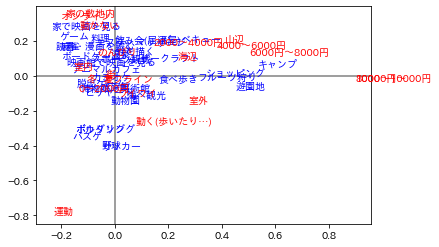

In [534]:
# 表側
plt.scatter(rows[:, 0], rows[:, 1], c='b', marker="None")
labels = playlist.index
for label, x, y in zip(labels, rows[:, 0], rows[:, 1]):
    plt.annotate(label, xy=(x, y), c="b")
    
# 表頭
plt.scatter(cols[:, 0], cols[:, 1], c='r', marker="None")
labels = playlist.columns
for label, x, y in zip(labels, cols[:, 0], cols[:, 1]):
    plt.annotate(label, xy=(x, y), c="r")
 
# xy軸
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

In [535]:
# 遊び特徴量
fun_features = pd.DataFrame(rows).set_index(playlist.index)
fun_features

,0,1
遊び,,
バーベキュー,0.175642,0.195685
キャンプ,0.533430,0.042991
温泉,-0.014468,0.108278
博物館・美術館,-0.128758,-0.087900
飲み会(居酒屋),-0.000065,0.181542
ショッピング,0.339861,-0.009469
遊園地,0.452419,-0.074893
動物園,-0.015816,-0.155217
水族館,-0.053539,-0.076580


## モジュールの確認

In [576]:
%load_ext autoreload
%autoreload 2
from modules import multiple_correspondence_analysis as mca_module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [577]:
json = [{"id":1,"name":"バーベキュー","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":1,"sea":1,"nonbiri":0,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":0,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.487Z","updated_at":"2021-09-09T06:22:52.487Z"},{"id":2,"name":"キャンプ","indoor":0,"outdoor":1,"summer":1,"winter":0,"house":0,"town":0,"mountain":1,"sea":1,"nonbiri":1,"waiwai":1,"dont_move":1,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":1,"to_8000yen":1,"to_10000yen":1,"over_10000yen":1,"created_at":"2021-09-09T06:22:52.493Z","updated_at":"2021-09-09T06:22:52.493Z"},{"id":3,"name":"温泉","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":1,"sea":1,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.499Z","updated_at":"2021-09-09T06:22:52.499Z"},{"id":4,"name":"博物館・美術館","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.504Z","updated_at":"2021-09-09T06:22:52.504Z"},{"id":5,"name":"飲み会(居酒屋)","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.509Z","updated_at":"2021-09-09T06:22:52.509Z"},{"id":6,"name":"ショッピング","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":1,"over_10000yen":1,"created_at":"2021-09-09T06:22:52.513Z","updated_at":"2021-09-09T06:22:52.513Z"},{"id":7,"name":"遊園地","indoor":1,"outdoor":1,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":1,"to_8000yen":1,"to_10000yen":1,"over_10000yen":1,"created_at":"2021-09-09T06:22:52.518Z","updated_at":"2021-09-09T06:22:52.518Z"},{"id":8,"name":"動物園","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.523Z","updated_at":"2021-09-09T06:22:52.523Z"},{"id":9,"name":"水族館","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":1,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.527Z","updated_at":"2021-09-09T06:22:52.527Z"},{"id":10,"name":"カラオケ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":1,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.533Z","updated_at":"2021-09-09T06:22:52.533Z"},{"id":11,"name":"料理","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.538Z","updated_at":"2021-09-09T06:22:52.538Z"},{"id":12,"name":"ボルダリング","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.543Z","updated_at":"2021-09-09T06:22:52.543Z"},{"id":13,"name":"海へ観光","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":1,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.548Z","updated_at":"2021-09-09T06:22:52.548Z"},{"id":14,"name":"食べ歩き","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.554Z","updated_at":"2021-09-09T06:22:52.554Z"},{"id":15,"name":"フルーツ狩り","indoor":0,"outdoor":1,"summer":1,"winter":0,"house":0,"town":0,"mountain":1,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":0,"to_4000yen":1,"to_6000yen":1,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.560Z","updated_at":"2021-09-09T06:22:52.560Z"},{"id":16,"name":"アニマルカフェ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.565Z","updated_at":"2021-09-09T06:22:52.565Z"},{"id":17,"name":"サッカー","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.571Z","updated_at":"2021-09-09T06:22:52.571Z"},{"id":18,"name":"バスケ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.576Z","updated_at":"2021-09-09T06:22:52.576Z"},{"id":19,"name":"野球","indoor":0,"outdoor":1,"summer":1,"winter":1,"house":0,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.580Z","updated_at":"2021-09-09T06:22:52.580Z"},{"id":20,"name":"映画館で映画を見る","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.585Z","updated_at":"2021-09-09T06:22:52.585Z"},{"id":21,"name":"読書・漫画を読む","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.591Z","updated_at":"2021-09-09T06:22:52.591Z"},{"id":22,"name":"絵を描く","indoor":1,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":1,"sea":1,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.597Z","updated_at":"2021-09-09T06:22:52.597Z"},{"id":23,"name":"レザークラフト","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":1,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.603Z","updated_at":"2021-09-09T06:22:52.603Z"},{"id":24,"name":"脱出ゲーム","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.608Z","updated_at":"2021-09-09T06:22:52.608Z"},{"id":25,"name":"ゲーム","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.613Z","updated_at":"2021-09-09T06:22:52.613Z"},{"id":26,"name":"ボウリング","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":0,"move":1,"exercise":1,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.618Z","updated_at":"2021-09-09T06:22:52.618Z"},{"id":27,"name":"ビリヤード","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":0,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":0,"move":1,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.624Z","updated_at":"2021-09-09T06:22:52.624Z"},{"id":28,"name":"麻雀","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.629Z","updated_at":"2021-09-09T06:22:52.629Z"},{"id":29,"name":"ボードゲーム","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":0,"waiwai":1,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.635Z","updated_at":"2021-09-09T06:22:52.635Z"},{"id":30,"name":"スポーツ観戦","indoor":1,"outdoor":1,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":1,"dont_move":1,"move":1,"exercise":0,"online":1,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.640Z","updated_at":"2021-09-09T06:22:52.640Z"},{"id":31,"name":"エステ・マッサージ","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":1,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":0,"offline":1,"to_2000yen":1,"to_4000yen":1,"to_6000yen":1,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.645Z","updated_at":"2021-09-09T06:22:52.645Z"},{"id":32,"name":"家で映画を見る","indoor":1,"outdoor":0,"summer":1,"winter":1,"house":1,"town":0,"mountain":0,"sea":0,"nonbiri":1,"waiwai":0,"dont_move":1,"move":0,"exercise":0,"online":1,"offline":1,"to_2000yen":0,"to_4000yen":0,"to_6000yen":0,"to_8000yen":0,"to_10000yen":0,"over_10000yen":0,"created_at":"2021-09-09T06:22:52.650Z","updated_at":"2021-09-09T06:22:52.650Z"}]

In [578]:
mca_module.run(json)

# 遊びレコメンドモデル(ガウス過程回帰)の構築

## 遊び特徴量の取得

In [10]:
fun_features = pd.read_csv('/home/workspace/data/fun_features.csv', index_col=0)

In [11]:
fun_features.T

id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.175642,0.533430,-0.014468,-0.128758,-0.000065,0.339861,0.452419,-0.015816,-0.053539,-0.085669,...,0.057593,-0.143697,-0.209303,-0.14931,-0.112595,-0.202759,-0.201434,-0.087142,-0.069134,-0.237555
1,0.195685,0.042991,0.108278,-0.087900,0.181542,-0.009469,-0.074893,-0.155217,-0.076580,-0.025432,...,0.082604,-0.056582,0.206861,-0.32398,-0.107601,0.149249,0.089424,0.077350,0.173947,0.265869


## 目的変数の取得

In [81]:
y_json = [{"id":1,"hangout_id":19,"fun_score":2},{"id":2,"hangout_id":8,"fun_score":4},{"id":3,"hangout_id":5,"fun_score":5},{"id":4,"hangout_id":13,"fun_score":1},{"id":5,"hangout_id":3,"fun_score":5}]

In [82]:
for i, one_json in enumerate(y_json):
    shaping_json = {"{}".format(i): one_json} 
    input_json = str(shaping_json).replace("'", '"')
    se_y = pd.read_json(input_json) # json to Series
    # 初回だけdfにseを代入し，2回目以降はdfとseを結合する
    df_y = se_y if i == 0 else pd.concat([df_y, se_y], axis=1)
df_y  = df_y.reindex(index=y_json[0].keys()) # indexの順番をjsonと同じにする

In [83]:
df_y.drop(['id'], inplace=True)

In [84]:
df_y = df_y.T
df_y

,hangout_id,fun_score
0,19,2
1,8,4
2,5,5
3,13,1
4,3,5


## 学習セットの作成

In [85]:
x_train = fun_features.loc[df_y['hangout_id']]

In [86]:
x_train

,0,1
id,,
19,-0.050104,-0.415164
8,-0.015816,-0.155217
5,-0.000065,0.181542
13,0.045284,-0.130143
3,-0.014468,0.108278


In [87]:
y_train = pd.DataFrame(df_y['fun_score'])
y_train

,fun_score
0,2
1,4
2,5
3,1
4,5


In [88]:
dim = len(x_train.columns)
#kernel = GPy.kern.Matern32(dim) + GPy.kern.Linear(dim) + GPy.kern.Bias(dim) + GPy.kern.White(dim)
kernel = GPy.kern.RBF(dim) + GPy.kern.Linear(dim) + GPy.kern.Bias(dim) + GPy.kern.White(dim)

model = GPy.models.GPRegression(x_train, y_train, kernel)
model.optimize()

In [89]:
y_qua_pred = model.predict_quantiles(fun_features.values, quantiles=(5, 50, 95))
y_pred = pd.DataFrame(np.array(y_qua_pred).reshape(3,len(y_qua_pred[0])).T)
y_pred.index = fun_features.index
y_pred.columns = ["5%","expected value","95%"]
y_pred.head()

,5%,expected value,95%
id,,,
1,0.894782,3.959593,7.024404
2,-1.705214,2.602957,6.911127
3,1.312707,4.025594,6.738481
4,0.680765,3.437735,6.194705
5,1.402111,4.205514,7.008917


In [90]:
expected_value = y_pred["expected value"]
expected_value_mm = _calc_minmaxscaler(expected_value)
variation = y_pred["95%"] - y_pred["5%"]
variation_mm = _calc_minmaxscaler(variation)

In [91]:
def _calc_minmaxscaler(values):
    input_values = values.values.reshape(-1,1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(input_values)

In [92]:
A = 0.5
B = 1 - A
# 期待値が高く,ばらつきが大きい(今までに経験してない)遊びをレコメンドしたい気持ちが込められてる
eval_vals = A * expected_value_mm + B * variation_mm

In [93]:
df_eval_vals = pd.DataFrame(eval_vals, index=y_pred.index, columns=["eval_val"])
df_eval_vals.sort_values("eval_val", ascending=False)

,eval_val
id,
32,0.716896
25,0.644477
2,0.622200
21,0.608637
28,0.590020
11,0.552328
29,0.538103
1,0.528736
31,0.519002


In [95]:
y_pred_sort = y_pred.sort_values("95%", ascending=False)
y_pred_sort # 上位5位まで

,5%,expected value,95%
id,,,
32,1.082461,4.444026,7.805591
25,1.163398,4.348417,7.533437
21,1.074607,4.224688,7.374769
28,1.127247,4.218989,7.310731
11,1.416530,4.315809,7.215087
29,1.030008,4.058366,7.086724
31,1.412689,4.247446,7.082203
1,0.894782,3.959593,7.024404
5,1.402111,4.205514,7.008917


## jsonへ 

In [680]:
y_pred_95 = y_pred["95%"]
y_pred_95.head()

id
1    7.024404
2    6.911127
3    6.738481
4    6.194705
5    7.008917
Name: 95%, dtype: float64

In [681]:
y_pred_json = []
for i, val in enumerate(y_pred_95):
    y_pred_json.append(dict(id=i, val=val))

In [682]:
y_pred_json

[{'id': 0, 'val': 7.024404110332121},
 {'id': 1, 'val': 6.911126936403074},
 {'id': 2, 'val': 6.738480734759004},
 {'id': 3, 'val': 6.194704689168727},
 {'id': 4, 'val': 7.00891736032013},
 {'id': 5, 'val': 6.469744084031685},
 {'id': 6, 'val': 6.4314005641459975},
 {'id': 7, 'val': 5.714619780471267},
 {'id': 8, 'val': 6.070614081562267},
 {'id': 9, 'val': 6.334530098473504},
 {'id': 10, 'val': 7.2150871501615335},
 {'id': 11, 'val': 5.395503879322347},
 {'id': 12, 'val': 5.758166772223552},
 {'id': 13, 'val': 6.141801731229988},
 {'id': 14, 'val': 6.355078734495746},
 {'id': 15, 'val': 6.713219114749764},
 {'id': 16, 'val': 4.93157714053274},
 {'id': 17, 'val': 5.304745531647475},
 {'id': 18, 'val': 4.93157714053274},
 {'id': 19, 'val': 6.915538517506521},
 {'id': 20, 'val': 7.374769089590442},
 {'id': 21, 'val': 6.773711205353071},
 {'id': 22, 'val': 6.575192306451184},
 {'id': 23, 'val': 6.357041775804488},
 {'id': 24, 'val': 7.5334372764792},
 {'id': 25, 'val': 5.395503879322348},

## モジュールの確認

In [113]:
%load_ext autoreload
%autoreload 2
from modules import fun_recommendation as fr_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
y_json = [{"id":1,"hangout_id":19,"fun_score":2},{"id":2,"hangout_id":8,"fun_score":4},{"id":3,"hangout_id":5,"fun_score":5},{"id":4,"hangout_id":13,"fun_score":1},{"id":5,"hangout_id":3,"fun_score":5}]

In [115]:
fr_model.run(y_json)

[{'id': 0, 'val': 0.5287360042786998},
 {'id': 1, 'val': 0.6221995030100949},
 {'id': 2, 'val': 0.43702885092873067},
 {'id': 3, 'val': 0.3295800471819671},
 {'id': 4, 'val': 0.5010207776634023},
 {'id': 5, 'val': 0.4551802026380587},
 {'id': 6, 'val': 0.49171618412262164},
 {'id': 7, 'val': 0.2197398828195426},
 {'id': 8, 'val': 0.2932187389186106},
 {'id': 9, 'val': 0.3517889611166295},
 {'id': 10, 'val': 0.5523276580806086},
 {'id': 11, 'val': 0.18134728551882895},
 {'id': 12, 'val': 0.2301369972871794},
 {'id': 13, 'val': 0.3287543903330309},
 {'id': 14, 'val': 0.41929762829025463},
 {'id': 15, 'val': 0.446045552465143},
 {'id': 16, 'val': 0.08606642118159435},
 {'id': 17, 'val': 0.1687555010814632},
 {'id': 18, 'val': 0.08606642118159435},
 {'id': 19, 'val': 0.4954178809190324},
 {'id': 20, 'val': 0.6086372926375493},
 {'id': 21, 'val': 0.4455208654113463},
 {'id': 22, 'val': 0.4038102529938008},
 {'id': 23, 'val': 0.3663574026310419},
 {'id': 24, 'val': 0.6444766760109576},
 {'id

In [109]:
df_eval_vals

,eval_val
id,
1,0.528736
2,0.622200
3,0.437029
4,0.329580
5,0.501021
6,0.455180
7,0.491716
8,0.219740
9,0.293219
